In [1]:
import pandas as pd
df=pd.read_csv('pre_processed2.csv')
print(df.head())

   Unnamed: 0.1  Unnamed: 0  Marital Status  Application mode  \
0             0           0               1                17   
1             1           1               1                15   
2             2           2               1                 1   
3             3           3               1                17   
4             4           4               2                39   

   Application order  Course  Daytime/evening attendance  \
0                  5     171                           1   
1                  1    9254                           1   
2                  5    9070                           1   
3                  2    9773                           1   
4                  1    8014                           0   

   Previous qualification  Previous qualification (grade)  Nationality  ...  \
0                       1                           122.0            1  ...   
1                       1                           160.0            1  ...   
2          

# Characteristics related to academic performance
1. Create a composite grade profile that average first and second semester grades so as to reflect a student's overall performance.
2. Total pass rate may be strongly related to whether or not a student dropout or enrolled or graduate
3. Total missed rate may also related to students' dropout, enrolled, or graduate.

In [2]:
# average grade
df["Avg Grade"]=(df["Curricular units 1st sem (grade)"] + df["Curricular units 2nd sem (grade)"])/2
# passing rate
df["Total Pass Rate"] = (df["Curricular units 1st sem (approved)"] + df["Curricular units 2nd sem (approved)"]) / \
                        (df["Curricular units 1st sem (enrolled)"] + df["Curricular units 2nd sem (enrolled)"])
#  missed rate
df['Total Missed Rate'] = (df["Curricular units 1st sem (without evaluations)"] + df["Curricular units 2nd sem (without evaluations)"]) / \
                            (df["Curricular units 1st sem (enrolled)"] + df["Curricular units 2nd sem (enrolled)"])



# Impact of economic factors
1. High financial pressures may influence students' decisions about whether continue their education or not. This three influences here can be simply added or subtracted linearly due to normalization. GDP is the obvious negative correlate, so subtraction is fine.

In [3]:
# economic 
df["Economic Pressure Index"] = df["Unemployment rate"] + df["Inflation rate"] - df["GDP"]

In [4]:
columns_to_fill = ["Total Pass Rate", "Total Missed Rate"]

for col in columns_to_fill:
    if col in df.columns:
        df[col] = df[col].fillna(0)
print(df.head())

   Unnamed: 0.1  Unnamed: 0  Marital Status  Application mode  \
0             0           0               1                17   
1             1           1               1                15   
2             2           2               1                 1   
3             3           3               1                17   
4             4           4               2                39   

   Application order  Course  Daytime/evening attendance  \
0                  5     171                           1   
1                  1    9254                           1   
2                  5    9070                           1   
3                  2    9773                           1   
4                  1    8014                           0   

   Previous qualification  Previous qualification (grade)  Nationality  ...  \
0                       1                           122.0            1  ...   
1                       1                           160.0            1  ...   
2          

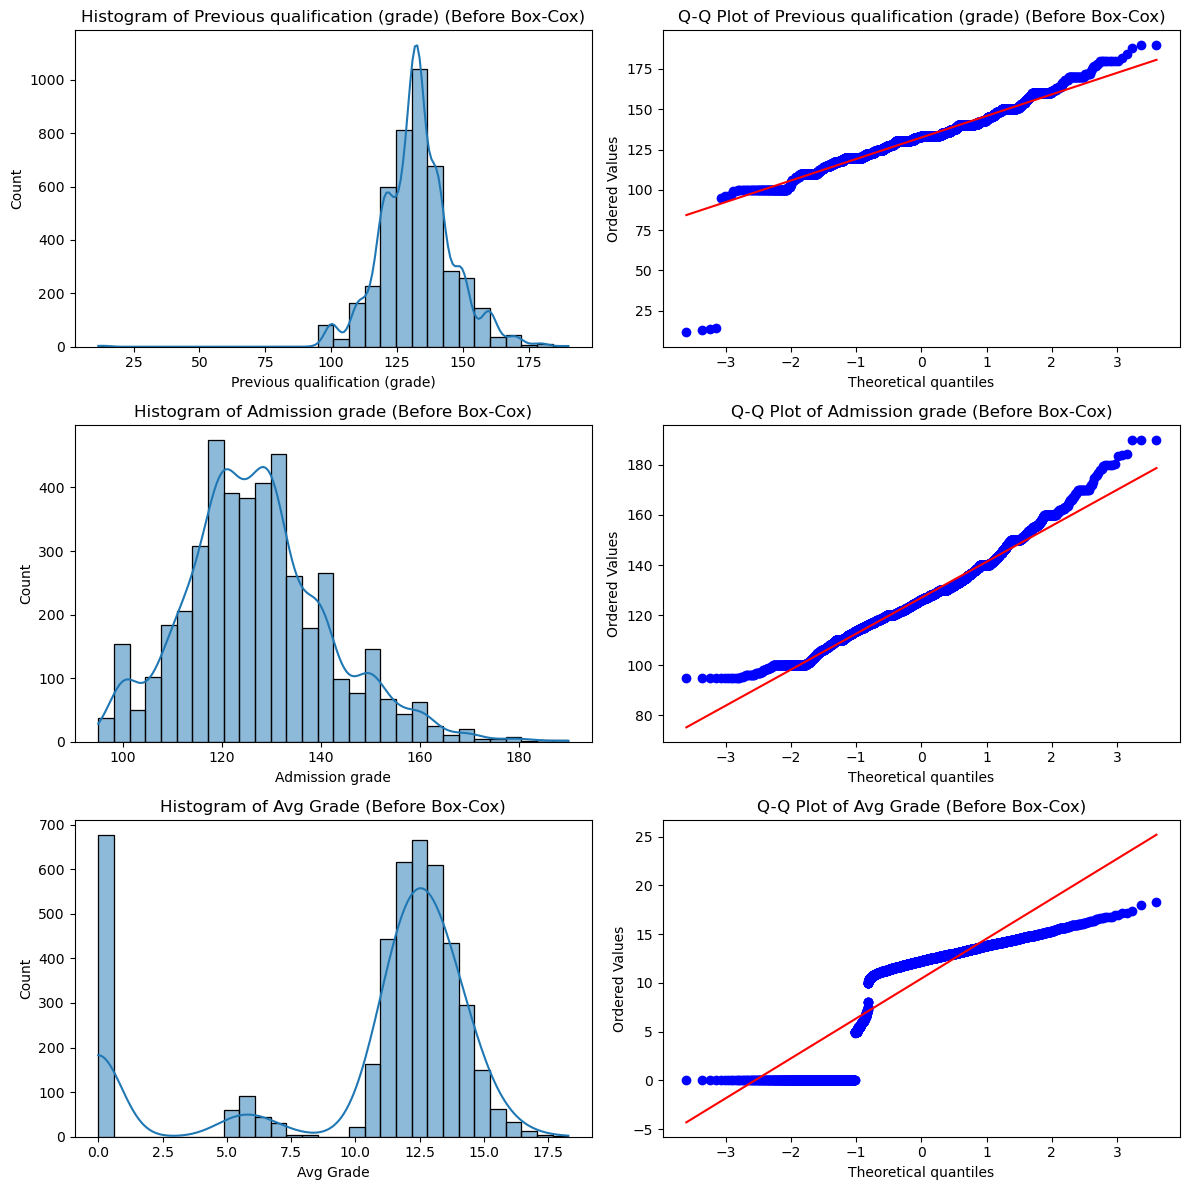

In [5]:
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

boxcox_columns = ["Previous qualification (grade)", "Admission grade", "Avg Grade"]

fig, axes = plt.subplots(len(boxcox_columns), 2, figsize=(12, 12))

for i, col in enumerate(boxcox_columns):
    if col in df.columns:
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f"Histogram of {col} (Before Box-Cox)")

        stats.probplot(df[col], dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title(f"Q-Q Plot of {col} (Before Box-Cox)")

plt.tight_layout()
plt.show()

The Q-Q plots and histograms show that the data is skewed. In order to make the data more consistent with a normal distribution and thus improve the model's performance, we do BOX-COX to the data.

Optimal λ for Previous qualification (grade): 1.429706715413598
Optimal λ for Admission grade: -0.41711485753748523
Since there are some datas smaller or equal to 0, we shift them
Optimal λ for Avg Grade: 1.7227735348499589


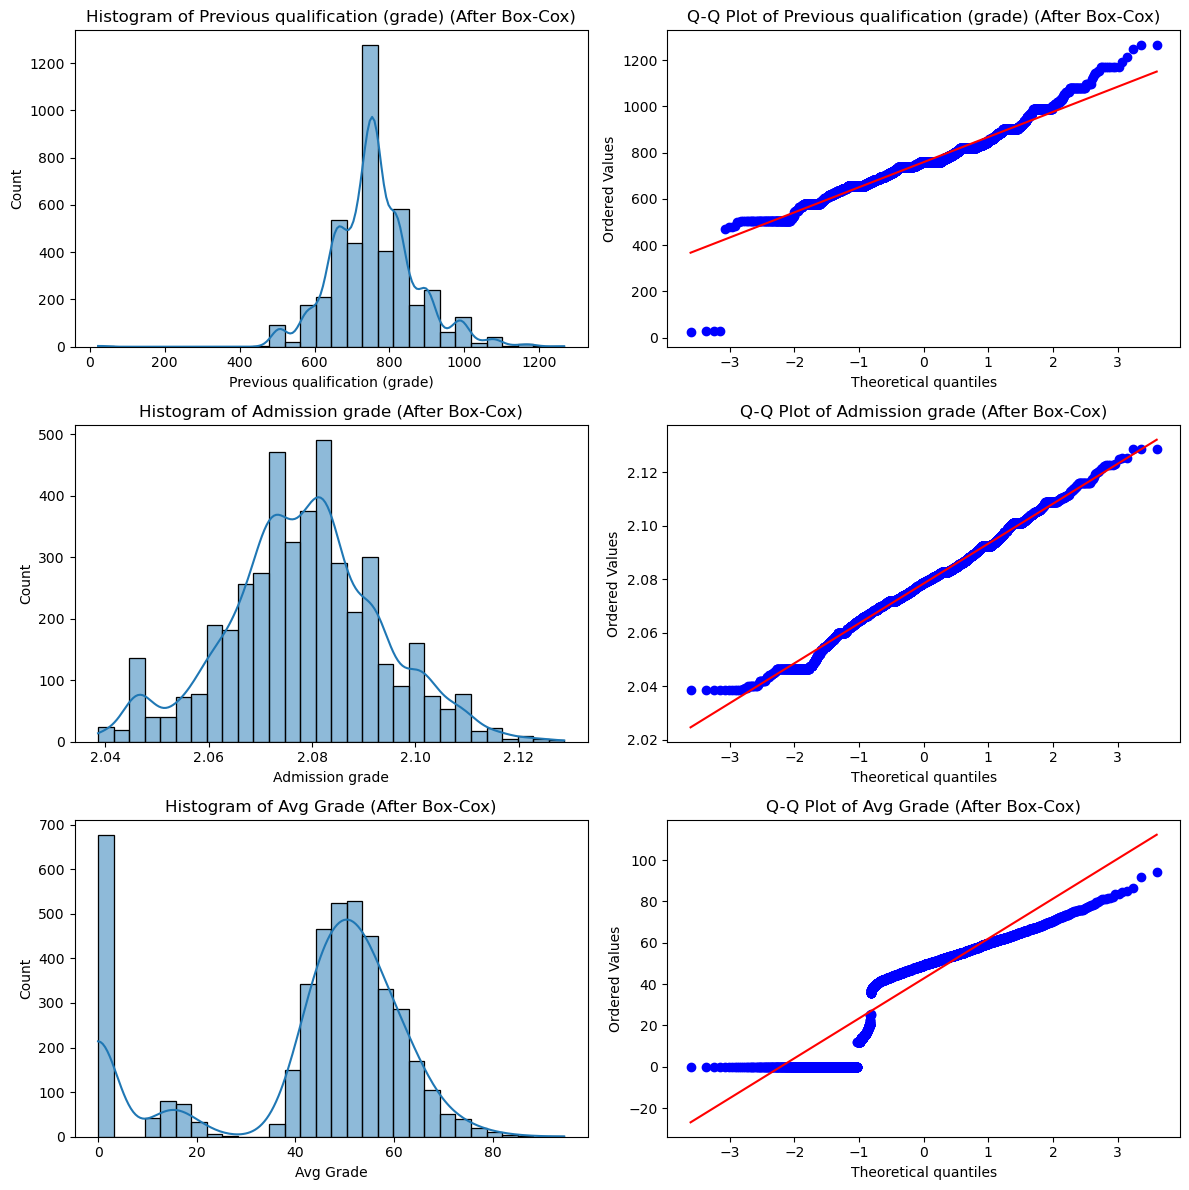

In [6]:
for col in  boxcox_columns:
    if col in df.columns:
        if (df[col] <= 0).any():
            print('Since there are some datas smaller or equal to 0, we shift them')
            shift = abs(df[col].min()) + 1 
            df[col] = df[col] + shift

        df[col], lambda_val = boxcox(df[col])
        print(f"Optimal λ for {col}: {lambda_val}")

fig, axes = plt.subplots(len( boxcox_columns), 2, figsize=(12, 12))

for i, col in enumerate( boxcox_columns):
    if col in df.columns:
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f"Histogram of {col} (After Box-Cox)")

        stats.probplot(df[col], dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title(f"Q-Q Plot of {col} (After Box-Cox)")

plt.tight_layout()
plt.show()

<font color='red'>Since there are many zeros in "Avg Grade", thun, even though we do Box-Cox to the data, it still shows a non-normal distribution.<font>

# Interactive features

1. Age x Admission grade

Examine the interaction between student age and admissions grades to see if older students need higher admissions scores to be successful. If the older students with high admissions grades but still have high rate of dropout, it might mean they are facing other additional stresses like finance, and family responsibilities.


2. Scholarship holder x Pass rate

Students with scholarships are likely to be more academically focused (because they need to maintain their grades in order to continue to receive financial aid), so the interaction term between scholarships and pass rates can measure the impact of financial incentives on academic success.

3. Daytime attendance x Pass rate

Students on daytime and evening courses may have different learning styles, and students on evening courses may be part-time workers with restricted study hours, so different attendance times may affect pass rates.

In [7]:
df["Age x Admission grade"] = df["Age at enrollment"] * df["Admission grade"]
df["Scholarship holder x Pass rate"] = df["Scholarship holder"] * df["Total Pass Rate"]
df["Daytime attendance x Pass rate"] = df["Daytime/evening attendance"] * df["Total Pass Rate"]


print(df[["Age x Admission grade", "Scholarship holder x Pass rate", "Daytime attendance x Pass rate"]].head())


   Age x Admission grade  Scholarship holder x Pass rate  \
0              41.597760                             0.0   
1              39.795149                             0.0   
2              39.467752                             0.0   
3              41.430312                             0.0   
4              94.211565                             0.0   

   Daytime attendance x Pass rate  
0                        0.000000  
1                        1.000000  
2                        0.000000  
3                        0.916667  
4                        0.000000  


# Normalization of numericial data

In [8]:
from sklearn.preprocessing import MinMaxScaler

continuous_columns = [
    "Previous qualification (grade)", "Admission grade", "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)", "Unemployment rate", "Inflation rate", "GDP",
    "Avg Grade", "Total Pass Rate", "Total Missed Rate", "Economic Pressure Index",
    "Age x Admission grade", "Scholarship holder x Pass rate", "Daytime attendance x Pass rate"
]


scaler = MinMaxScaler()

for col in continuous_columns:
    if col in df.columns:
        df[col] = scaler.fit_transform(df[[col]])
        df.rename(columns={col: col + " After Normalization"}, inplace=True)

In [9]:
print(df.head())

   Unnamed: 0.1  Unnamed: 0  Marital Status  Application mode  \
0             0           0               1                17   
1             1           1               1                15   
2             2           2               1                 1   
3             3           3               1                17   
4             4           4               2                39   

   Application order  Course  Daytime/evening attendance  \
0                  5     171                           1   
1                  1    9254                           1   
2                  5    9070                           1   
3                  2    9773                           1   
4                  1    8014                           0   

   Previous qualification  Previous qualification (grade) After Normalization  \
0                       1                                           0.521985    
1                       1                                           0.778067    
2    

In [10]:
df.to_csv('final_clean.csv')